In [1]:
# limit visible GPUs so TF only blocks memory on one
import os
os.environ['CUDA_VISIBLE_DEVICES']=str(1)

In [2]:
from finetune import FineTuneCNN
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import pandas as pd
import re
import numpy as np
import copy
import datetime
from utils import *
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


### Define model parameters and data paths

In [3]:
# after testing, these learning rates and training depths worked fairly well
model_archs = {"VGG16":{"train_after_layer":14, "lr":0.0001},
               "VGG19":{"train_after_layer":16, "lr":0.0001},
               "InceptionV3":{"train_after_layer":172,"lr":0.001},
               "ResNet50":{"train_after_layer":142, "lr":0.001},
               "Xception":{"train_after_layer":95, "lr":0.01},
              }

In [4]:
data_dir = "/home/ai2-c3p0/Documents/code/todd_working_directory/KaggleFisheries/data/"
train_path = data_dir+"train_split/"
val_path = data_dir + "val_split/"
test_path = data_dir + "test_split/"
inference_path = data_dir + "test_stg1_keras/"
submission_path = data_dir + "submissions/"
model_path = data_dir + "models/"
log_file = data_dir + "log_files/log.txt"
num_classes = len([dir_ for dir_ in os.listdir(train_path) if os.path.isdir(train_path+dir_)])
class_labels = sorted([class_label for class_label in os.listdir(train_path) if os.path.isdir(train_path)])
batch_size = 32
early_stopping = True # will stop training when the val_loss doesn't decrease by 0.1 or more between epochs
aug=False
num_training_samples=count_files(train_path)
num_validation_samples = count_files(val_path)
num_test_samples = count_files(test_path)
num_inference_samples = count_files(inference_path)
num_epochs = 10 # will likely stop well before 10 epochs
num_runs = 1 # number of models to train per model architecture

### Define functions to train, test, and predict

In [5]:
def train_model(save_checkpoint=False, archs=None):
    log = []
    for model_arch in archs:
        model_name = model_arch
        
        # Keras models appear to be correlated across runs, so re-initializing the model seems to alleviate the issue
        for i in range(num_runs):
            if model_arch == "VGG19":
                fresh_model = VGG19(include_top=False)
            elif model_arch == "VGG16":
                fresh_model = VGG16(include_top=False)
            elif model_arch == "InceptionV3":
                fresh_model = InceptionV3(include_top=False)
            elif model_arch == "ResNet50":
                fresh_model = ResNet50(include_top=False)
            elif model_arch == "Xception":
                fresh_model = Xception(include_top=False)

            log_str = "Model: {} -- Run number: {} -- Time: {}".format(model_name, i, datetime.datetime.now())
            print log_str
            temp_model = FineTuneCNN(model_name=model_name)

            temp_model.build(model_arch=fresh_model, num_classes=num_classes, lr=model_archs[model_name]['lr'], 
                             train_after_layer=model_archs[model_name]['train_after_layer'])

            if save_checkpoint:                
                save_path = model_path + model_name + "_run{}.hdf5".format(i)
                checkpoint = ModelCheckpoint(save_path, monitor='val_loss', verbose=0, save_best_only=True,
                                             save_weights_only=False, mode='auto', period=1)

            temp_model.train(train_path=train_path, num_training_samples=num_training_samples, validation_path=val_path, 
                             num_validation_samples=num_validation_samples, batch_size=batch_size, num_epochs=num_epochs, 
                             early_stopping=early_stopping, aug=aug, checkpoint=checkpoint)
            
            # log results
            log_string(log_file, log_str)
            val_loss = ['val_loss'] + temp_model.model.history.history['val_loss']
            val_accuracy = ['val_acc'] + temp_model.model.history.history['val_acc']
            log_string(log_file, str(val_loss+val_accuracy))
            log.append((model_name, i, val_loss, val_accuracy))
            
            K.clear_session()
    
    return log

In [6]:
def test_step(archs=None):
    temp_df = pd.DataFrame()
    for pre_trained in os.listdir(model_path):
        if os.path.isfile(model_path+pre_trained):
            model_name = pre_trained.split("_")[0]
            if model_name in archs:
                print pre_trained
                test_model = FineTuneCNN(model_name=model_name)
                test_model.load_weights(model_path+pre_trained)
                test_results = test_model.inference(test_path, num_test_samples, batch_size=batch_size, class_labels=class_labels)
                temp_df = temp_df.append(test_results)
                K.clear_session()
    return temp_df

In [7]:
def inference_step(archs=None):
    temp_df = pd.DataFrame()
    for pre_trained in os.listdir(model_path):
        if os.path.isfile(model_path+pre_trained):
            model_name = pre_trained.split("_")[0]
            if model_name in archs:
                print pre_trained
                inference_model = FineTuneCNN(model_name=model_name)
                inference_model.load_weights(model_path+pre_trained)
                inference_results = inference_model.inference(inference_path, num_inference_samples, batch_size=batch_size, class_labels=class_labels)
                temp_df = temp_df.append(inference_results)
                K.clear_session()
    return temp_df

### Train

In [8]:
save_checkpoint = True
test = True
archs = ["Xception","InceptionV3"]
log_output = train_model(save_checkpoint,archs)

Model: Xception -- Run number: 0 -- Time: 2017-03-16 14:29:06.648774
Model built.
Found 3019 images belonging to 8 classes.
Found 378 images belonging to 8 classes.
Epoch 1/10
3019/3019 [==============================] - 77s - loss: 1.0749 - acc: 0.6423 - val_loss: 0.8396 - val_acc: 0.7011

### Test

In [9]:
archs = ["Xception","InceptionV3"]
test_df = test_step(archs)

Xception_run0.hdf5
Found 380 images belonging to 8 classes.
InceptionV3_run0.hdf5
Found 380 images belonging to 8 classes.


In [10]:
ground_truth_labels = get_ground_truth_labels(test_path,num_test_samples,class_labels)

In [11]:
# average predictions across models to ensemble results
test_df = test_df.groupby(['image'],sort=False).mean().reset_index()

In [12]:
test_df['predicted_class'] = test_df[class_labels].idxmax(1)

In [13]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(test_df['predicted_class'])

LabelEncoder()

In [14]:
# log loss
print 'Log loss:', metrics.log_loss(label_encoder.transform(ground_truth_labels),test_df[class_labels].values)
# accuracy
print 'Accuracy:', metrics.accuracy_score(ground_truth_labels,test_df['predicted_class'])

Log loss: 0.166252405961
Accuracy: 0.947368421053


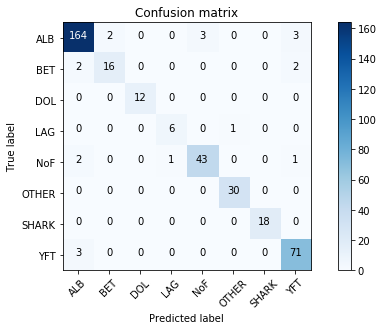

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truth_labels,test_df['predicted_class'])
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(8,4.5))
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix')

plt.show()

In [16]:
test_df['predicted_class'].value_counts()

ALB      171
YFT       77
NoF       46
OTHER     31
SHARK     18
BET       18
DOL       12
LAG        7
Name: predicted_class, dtype: int64

### Predict

In [17]:
archs = ["Xception","InceptionV3"]
inference_df = inference_step(archs)

Xception_run0.hdf5
Found 1000 images belonging to 1 classes.
InceptionV3_run0.hdf5
Found 1000 images belonging to 1 classes.


### Format and save predictions

In [18]:
# average the predictions from the models
final_df = inference_df.groupby(['image']).mean().reset_index()

In [19]:
len(final_df)

1000

In [20]:
final_df.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.006221,0.000860,0.000484,0.000248,0.990507,0.000356,0.001244,0.000079
1,img_00007.jpg,0.304114,0.346550,0.026015,0.033620,0.002287,0.089596,0.008255,0.189563
2,img_00009.jpg,0.884749,0.057369,0.002135,0.003901,0.000678,0.034101,0.007268,0.009799
3,img_00018.jpg,0.953605,0.013978,0.000378,0.001505,0.000202,0.027309,0.000251,0.002771
4,img_00027.jpg,0.416769,0.030084,0.010013,0.008309,0.024264,0.134506,0.047902,0.328154


In [21]:
final_df[class_labels].idxmax(1).value_counts()

ALB      578
YFT      196
NoF      125
OTHER     43
BET       26
LAG       15
SHARK      9
DOL        8
dtype: int64

In [22]:
final_df.to_csv(submission_path+"full_image_ensemble.csv",index=False)